# A Notebook To Accompany the centgovspend Library

This is a notebook to accompany the [centgovspend](https://github.com/crahal/centgovspend/) project. It first imports data and necessary libraries/modules, then outputs some summary statistics and a longitudinal over-view of the data which is aggregated by the library.

## Section 1: Importing tools

Lets first load our favourite tools! Everything here is pretty much bundled with Anaconda other than gender_guesser (```pip install gender_guesser```) and ezodf (```pip install ezodf```). A requirements.txt accompanies the repository.

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import re
import seaborn as sns
import math
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import glob
from collections import Counter
import matplotlib.patches as patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
import ntpath
from networkit import *
import networkit
import networkx as nx
from build_df_to_plot import (
    build_pesa_df, build_timely_df,
    trillions, billions, thousands,
    clean_occupations,
    clean_officer_names,
    clean_countries,
    clean_nationalities)
from network_analysis import (
    make_edgelist,
    add_datetimes,
    avgFriendDegree)
from clean_matches import clean_matches
import matplotlib as mpl
import gender_guesser.detector as gender
import numpy as np
from scipy import interpolate
import warnings
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings("ignore")
gendet = gender.Detector()
sns.set(style='ticks')
%matplotlib inline
%load_ext autoreload
%autoreload 2
repo = os.path.abspath(os.path.join('__file__',
                                    '../..',))

## Section 2: An introductory figure using OECD data

Data for this figure comes from [stats.oecd.org](https://stats.oecd.org/#)

### Section 2.1: Load in the OECD

In [2]:
centdebt_levels = pd.read_csv(os.path.join(repo, 'data',
                                           'OECD', 'oecd_q_centdebt_adj.csv'),
                                           parse_dates=['time'])
centdebt_pc = pd.read_csv(os.path.join(repo, 'data',
                                       'OECD', 'oecd_q_debt_pc.csv'))
gdp_levels = pd.read_csv(os.path.join(repo, 'data',
                                      'OECD', 'oecd_q_gdp.csv'))
fig1_df = pd.merge(centdebt_levels.rename({'original':'cent_debt_unadjusted',
                                           'adjusted':'cent_debt_adjusted'}, axis=1),
                   gdp_levels[['Period','Value']].rename({'Value':'GDP_LEVELS'},
                                                         axis=1),
                   how='left', left_index=True, right_index=True)
fig1_df = pd.merge(fig1_df, 
                   centdebt_pc[['Value']].rename({'Value':'OECD_PC_OF_GDP'},
                                                 axis=1),
                   how='left', left_index=True, right_index=True)
fig1_df['PC_OF_GDP_ADJUSTED'] = (fig1_df['cent_debt_adjusted']/
                                 fig1_df['GDP_LEVELS'])*100
fig1_df['quarter'] = pd.PeriodIndex(fig1_df.time, freq='Q')
fig1_df['cent_debt_adjusted'] = fig1_df['cent_debt_adjusted']/1000000
fig1_df['GDP_LEVELS'] = fig1_df['GDP_LEVELS']/1000000
fig1_df=fig1_df[20:]

### Section 2.2: Plot and annotate

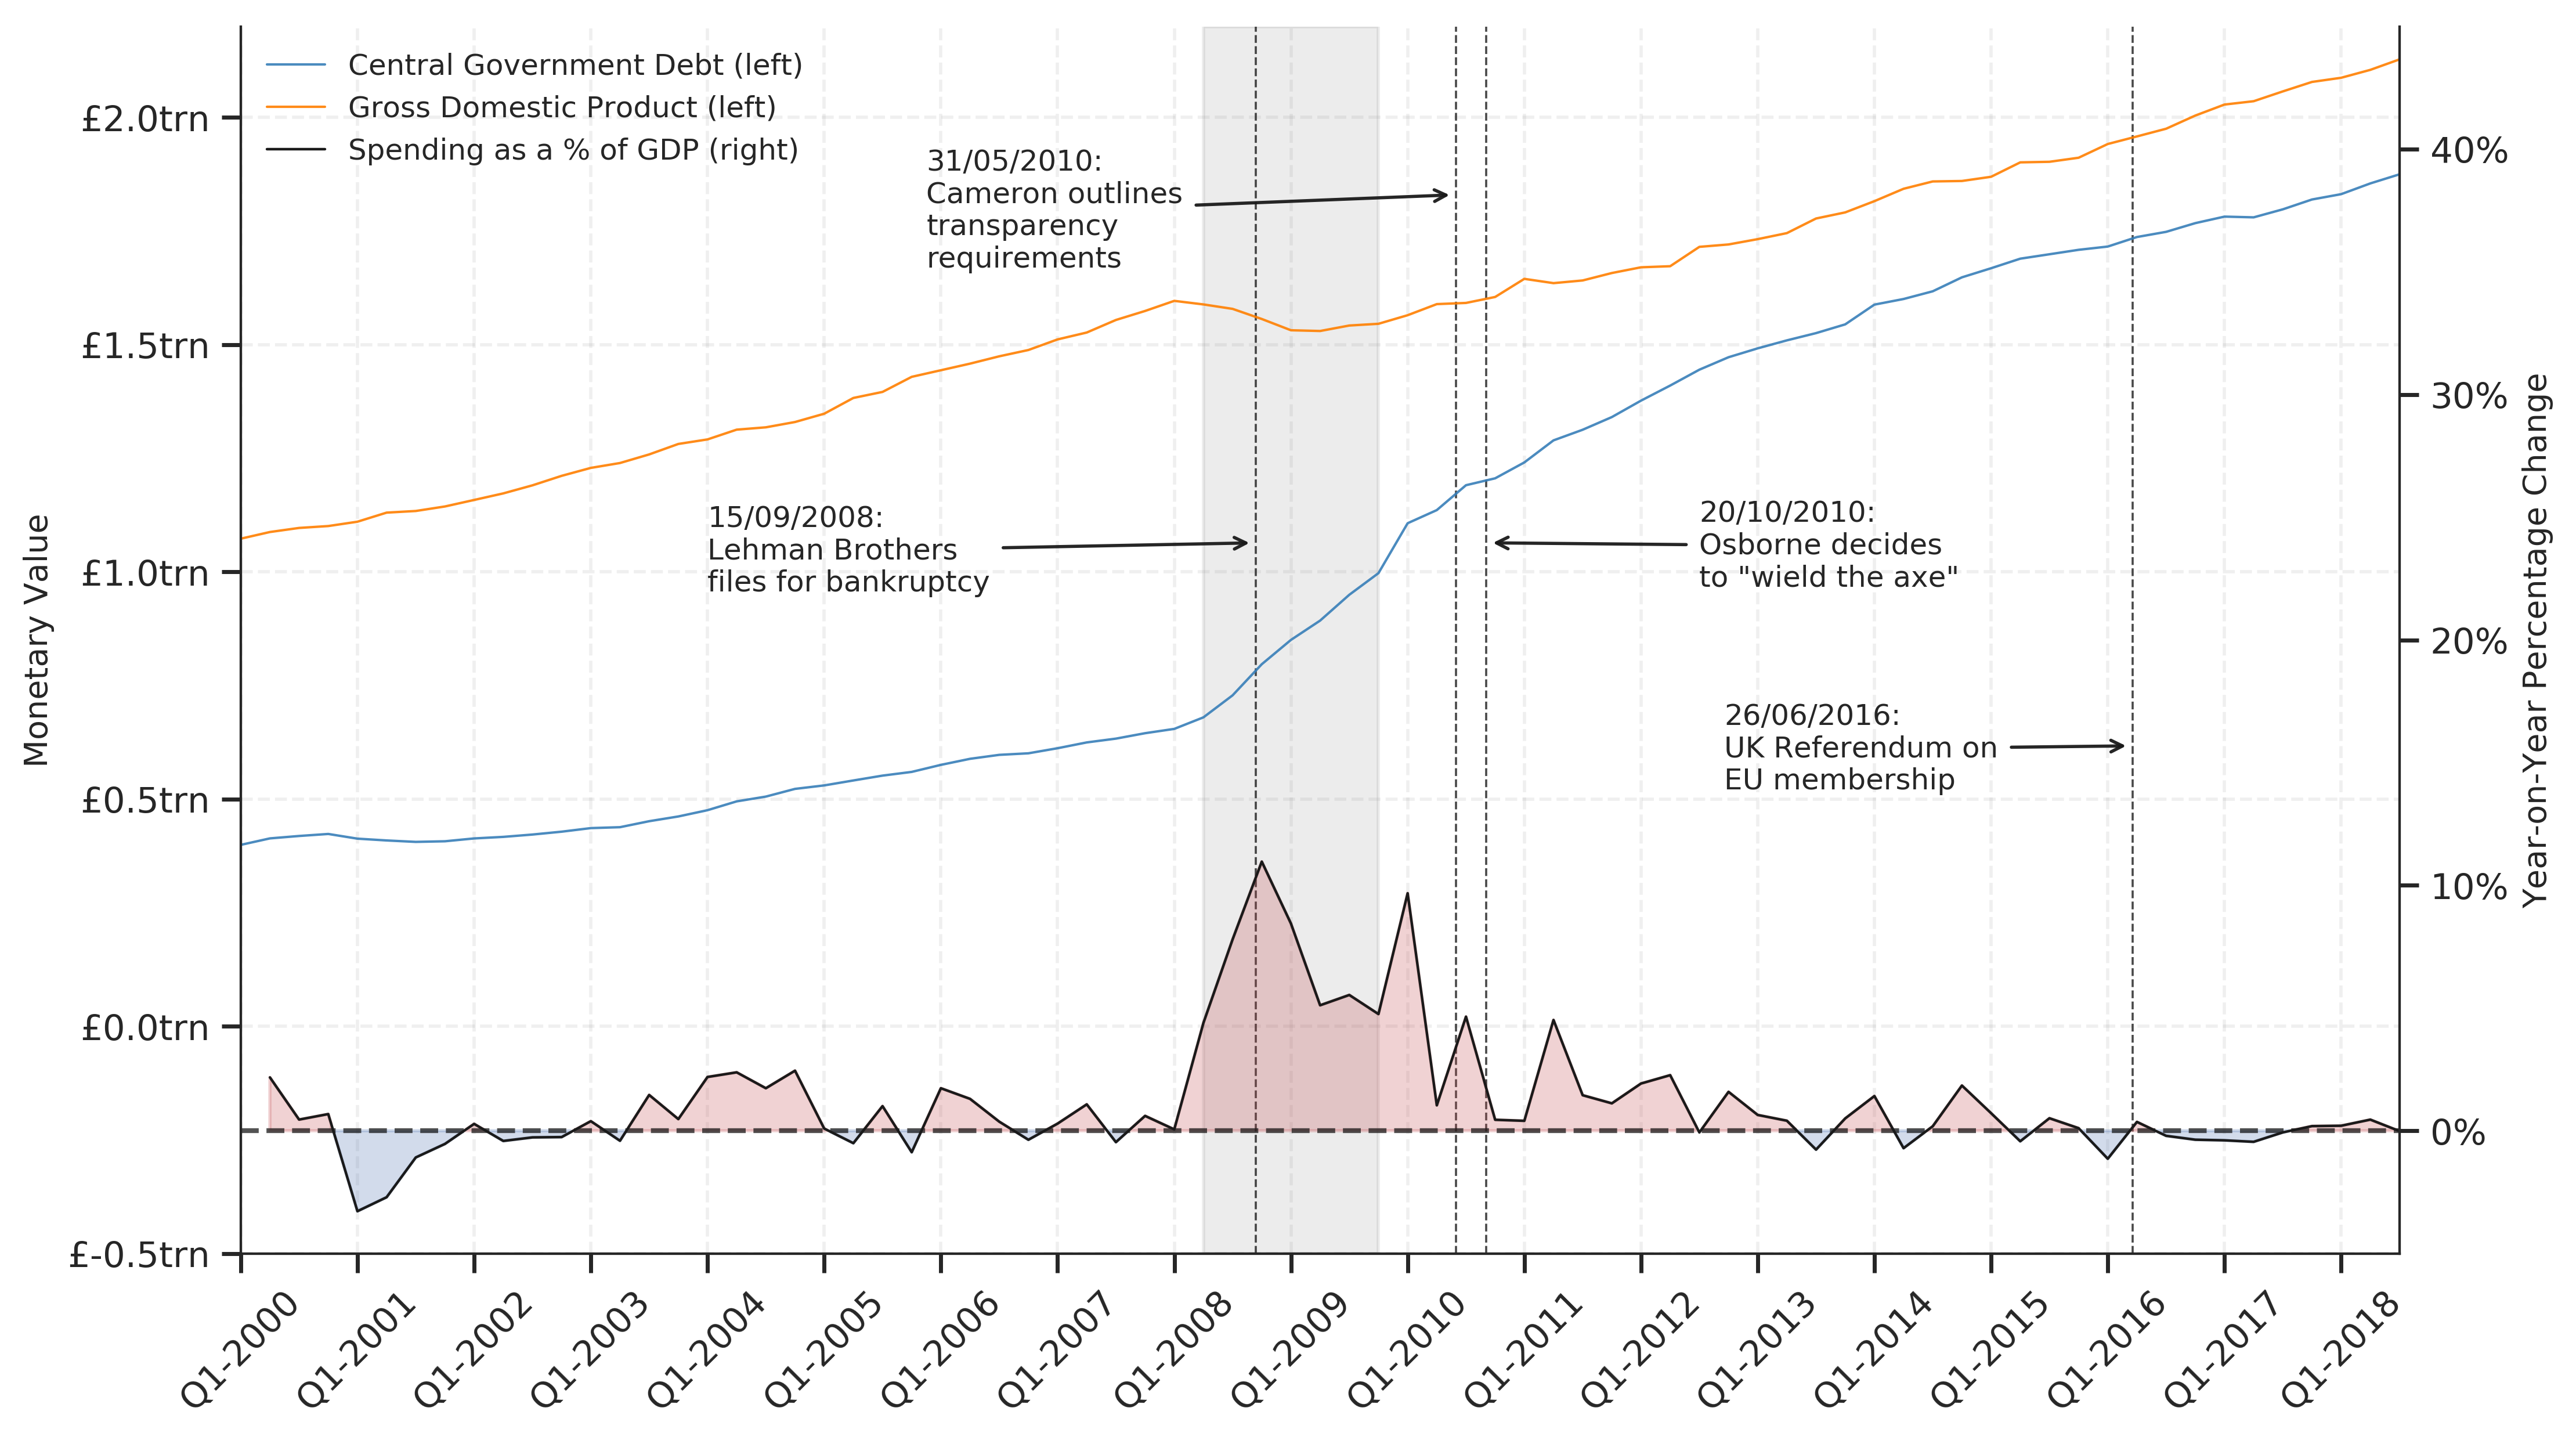

In [3]:
fig = plt.figure(figsize=(12, 7), dpi=400)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
lns1 = ax1.plot(fig1_df[['cent_debt_adjusted']],
                color='#377eb8', alpha=0.9, linewidth=0.75,
                label='Central Government Debt (left)')
lns2 = ax1.plot(fig1_df[['GDP_LEVELS']],
                color='#ff7f00', linewidth=0.75,
                alpha=0.9, label='Gross Domestic Product (left)')
lns3 = ax2.plot(fig1_df[['PC_OF_GDP_ADJUSTED']].pct_change(),
                color='k', linewidth=0.8, label='Spending as a % of GDP (right)')
ax1.axvspan(53, 59, alpha=0.15, color='gray')
y_data_array = np.array(fig1_df['PC_OF_GDP_ADJUSTED'].pct_change())
plot_x_axis = np.array(fig1_df['PC_OF_GDP_ADJUSTED'].index)
f = interpolate.interp1d(plot_x_axis, y_data_array)
xnew = np.arange(plot_x_axis[0], plot_x_axis[-1], 0.1)
ynew = f(xnew)
ax2.fill_between(xnew, 0, ynew, where=(ynew-1) < -1 , color='b', alpha=0.25)
ax2.fill_between(xnew, 0, ynew, where=(ynew-1) > -1 , color='r', alpha=0.25)    
ax1.vlines(x=61.66, ymin=-.5, ymax=fig1_df['GDP_LEVELS'].max()/.9,
           color='k', linestyle='--', alpha=0.8, linewidth=0.65)
ax1.annotate('31/05/2010:\nCameron outlines\ntransparency\nrequirements',
               xy=(61.66, fig1_df['GDP_LEVELS'].max()*0.86),
               xytext=(43.5, fig1_df['GDP_LEVELS'].max()*.785),
               arrowprops=dict(color='k', arrowstyle="->",
                               alpha=0.95), size=9)
ax1.vlines(x=62.7, ymin=-.5, ymax=fig1_df['GDP_LEVELS'].max()/.9,
           color='k', linestyle='--', alpha=0.8, linewidth=0.65)
ax1.annotate('20/10/2010:\nOsborne decides\nto "wield the axe"',
             xy=(62.7, fig1_df['GDP_LEVELS'].max()*0.5),
             xytext=(70, fig1_df['GDP_LEVELS'].max()*0.455),
             arrowprops=dict(color='k', arrowstyle="->",
                             alpha=0.95), size=9)
ax1.vlines(x=84.85, ymin=-.5, ymax=fig1_df['GDP_LEVELS'].max()/.9,
           color='k', linestyle='--', alpha=0.8, linewidth=0.65)
ax1.annotate('26/06/2016:\nUK Referendum on\nEU membership',
               xy=(84.85, fig1_df['GDP_LEVELS'].max()*0.29),
               xytext=(70.85, fig1_df['GDP_LEVELS'].max()*0.245),
               arrowprops=dict(color='k', arrowstyle="->",
                               alpha=0.95), size=9)
ax1.vlines(x=54.8, ymin=-.5, ymax=fig1_df['GDP_LEVELS'].max()/.9,
           color='k', linestyle='--', alpha=0.8, linewidth=0.65)
ax1.annotate('15/09/2008:\nLehman Brothers\nfiles for bankruptcy',
               xy=(54.8, fig1_df['GDP_LEVELS'].max()*0.5),
               xytext=(36, fig1_df['GDP_LEVELS'].max()*0.45),
               arrowprops=dict(color='k', arrowstyle="->",
                               alpha=0.95), size=9)
ax1.set_ylim(-.500000,2.2)
ax1.set_xlim(fig1_df.index[0], fig1_df.index[-1])
ax2.set_ylim(-.05,.45)
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left', frameon=False, fontsize=9)
ax1.set_xticks([i for i in fig1_df.index[::4]]);
ax1.set_xticklabels([i for i in fig1_df['Period'][::4]], rotation=45);
ax2.set_yticklabels(['{:,.0%}'.format(x) for x in ax2.get_yticks()])
ax1.set_ylabel('Monetary Value', fontsize=10)
ax2.set_ylabel('Year-on-Year Percentage Change', fontsize=10)
ax1.grid(b=True, which='both', color='gray', linestyle='--', alpha=0.125)
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(0.75)
    ax2.spines[axis].set_linewidth(0.75)
formatter = FuncFormatter(trillions)
ax1.yaxis.set_major_formatter(formatter)
ax2.hlines(y=0, xmin=fig1_df.index[0], xmax=fig1_df.index[-1],
            color='k', linestyle='--', alpha=0.75)
sns.despine(top=True,left=False,right=False,bottom=False)
fig.savefig(os.path.abspath(os.path.join(repo, 'compile', 'figures',
                                         'oecd_data.pdf')), bbox_inches='tight')
fig.savefig(os.path.abspath(os.path.join(repo, 'compile', 'figures',
                                         'oecd_data.png')), bbox_inches='tight',
            dpi=600)

## Section 3: Validation and Diagnostics

### Section 3.1: Build PESA table for comparison to allocations

In [4]:
pesa_table, list_of_files = build_pesa_df(os.path.abspath(
                                          os.path.join('__file__', '../..',
                                                       'data', 'PESA', 'PESA_data.csv')),
                                          os.path.abspath(
                                          os.path.join('__file__', '../..',
                                                       'data', 'output','mergeddepts', '*.csv')))

Which files have large perecents of missing dates? Is there some debugging which can be done here?

In [50]:
list_of_files['nulldates'] = list_of_files['nulldate_count']/list_of_files['full_count']
print('There are ' + str(len(list_of_files[list_of_files['nulldates']>0.05])) + 
      ' out of ' + str(len(list_of_files)) + 
      ' files (which have cleaned payments data) with > 5% dates missing.')
list_of_files[list_of_files['nulldates']>0.05].sort_values(by = 'nulldates', ascending=False)

There are 19 out of 1393 files (which have cleaned payments data) with > 5% dates missing.


,full_count,nulldate_count,dept,nulldates
file,,,,
dcms_spend_over_gbp25k_april_2013.csv,84,84.0,dcultmedsport,1.000000
dcms_spend_over_gbp25k_july_2013.csv,67,67.0,dcultmedsport,1.000000
dcms_spend_over_gbp25k_june_2013.csv,76,76.0,dcultmedsport,1.000000
dcms_spend_over_gbp25k_may_2013.csv,65,65.0,dcultmedsport,1.000000
dcms_transactions_over__25k_december_2015.csv,128,128.0,dcultmedsport,1.000000
dcms_transactions_over__25k_january_2016__1_.csv,91,91.0,dcultmedsport,1.000000
dcms_transactions_over__25k_november_2015.csv,79,79.0,dcultmedsport,1.000000
december-2010.csv,740,739.0,dfintdev,0.998649
dft-monthly-spend-201111.csv,7905,7579.0,dftransport,0.958760


### Section 3.2  Load in cleaned payments data for analysis

Lets load the main payments and reconciliation datasets generated by the library (outputs of ```centgovspend/src/centgovspend·py```):

In [6]:
payments = pd.read_csv(os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'output', 'master',
                 'All_Merged_Unmatched.csv')),
    encoding="ISO-8859-1", sep=',', engine='python',
    dtype={'transactionnumber': str,
           'supplier': str,
           'supplier_upper': str,
           'date': str,
           'expensearea': str,
           'expensetype': str,
           'file': str,
           'amount': float})
payments['date'] = payments['date'].apply(pd.to_datetime,
                                          dayfirst=True,
                                          errors = 'coerce')
replacedict = pd.read_csv((os.path.abspath(
    os.path.join('__file__', '../..', 'data',
                 'support', 'dept_names_dict.csv'))),
                          header=None,
                          dtype={0: str}).set_index(0).squeeze().to_dict()
for key, value in replacedict.items():
    payments['dept'] = payments['dept'].replace(key,value)
    
recon_sup = pd.read_csv(os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'output',
                 'master', 'Reconciled_Suppliers.tsv')),
    encoding="ISO-8859-1", sep='\t')
recon_sup = recon_sup.drop(['Disputed Office', 'Third Match',
                            'Third ID', 'Third Score'], axis=1)
matched = pd.merge(payments, recon_sup, how='left', left_on='supplier_upper',
    right_on='RawSupplier').dropna(subset=['Best Match'])

### Section 3.3: Build the timely df

In [7]:
timley_resetindex, timely_df = build_timely_df(payments)
barplot_df = pd.DataFrame(payments.groupby('dept')['file'].nunique())
barplot_df = pd.merge(barplot_df,
                      pd.DataFrame(payments.groupby('dept')['amount'].
                                   sum()).rename({'amount':'Value Sum'},
                                                 axis=1),
                      how = 'left', left_index = True, right_index = True)
barplot_df = pd.merge(barplot_df,
                      pd.DataFrame(payments.groupby('dept')['amount'].
                                   count()).rename({'amount':'Value Count'},
                                                   axis=1),
                      how = 'left', left_index = True, right_index = True)
barplot_df['Type'] = 'Ministerial'
for index in barplot_df.index:
    if index in ['C.Com', 'CMA', 'CPS','FSA', 'G.Acc','ForCom',
                 'LR','HMRC','NatAr','NSInv','ORail','ForCom	'
                 'OFGEM','OFQUAL','OFSTED','OFWAT','SF','SC',
                 'OFGEM	','OFGEM']:
        barplot_df.loc[index, 'Type'] = 'Non-Ministerial'
barplot_df.loc['OFGEM','Type'] = 'Non-Ministerial'                 

### Section 3.4 Plot the diagnose and validate figure

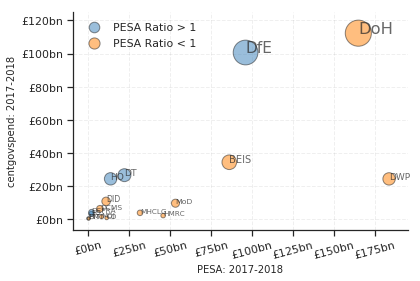

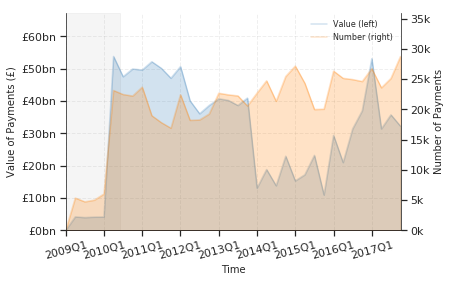

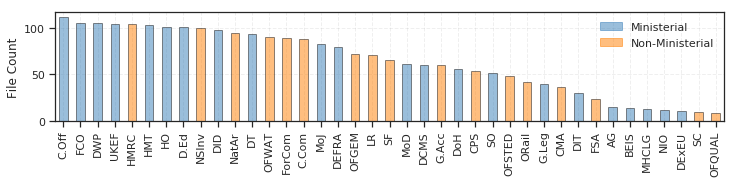

In [8]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(1, 1, 1)
pesa_high = pesa_table[pesa_table['Ratio_20172018']>1]
pesa_low = pesa_table[pesa_table['Ratio_20172018']<1]
ax_1 = pesa_high.plot.scatter(x='20172018Budget',
                              y='Raw_20172018_value',
                              s=8+pesa_high['Raw_20172018_value'].values*6,
                              alpha=0.5,
                              edgecolor='k',
                              color='#377eb8',
                              label='PESA Ratio > 1',
                              ax=ax1)
ax_1 = pesa_low.plot.scatter(x='20172018Budget',
                             y='Raw_20172018_value',
                             s=8+pesa_low['Raw_20172018_value'].values*6,
                             alpha=0.5,
                             edgecolor='k',
                             color = '#ff7f00',
                             label='PESA Ratio < 1',
                             ax=ax1)
ax_1.set_ylabel('centgovspend: 2017-2018', size=10)
ax_1.set_xlabel('PESA: 2017-2018', size=10)
formatter = FuncFormatter(billions)
ax_1.yaxis.set_major_formatter(formatter)
ax_1.xaxis.set_major_formatter(formatter)
for tick in ax_1.get_xticklabels():
    tick.set_rotation(15)
every_nth = 2
ax1.legend(loc='upper left', frameon=False, markerscale=0.6)
sns.despine(ax=ax_1)        
for i, txt in enumerate(pesa_table.index):
    ax_1.annotate(txt, (pesa_table.loc[txt, '20172018Budget'],
                        pesa_table.loc[txt, 'Raw_20172018_value']),
                  fontsize=7+pesa_table.loc[txt, 'Raw_20172018_value']/12,
                 alpha=0.7)
ax_1.grid(b=True, which='both', color='gray',
          linestyle='--', alpha=0.125)
fig.savefig(os.path.abspath(
            os.path.join('__file__', '../..','compile','figures',
                         'pesa.png')), dpi=800, bbox_inches='tight')
fig.savefig(os.path.abspath(
            os.path.join('__file__', '../..','compile','figures',
                         'pesa.pdf')), bbox_inches='tight')

fig = plt.figure(figsize=(6, 4))
ax2 = fig.add_subplot(1, 1, 1)
ax_2a = timley_resetindex[['Value of Payments']].plot(kind='area',
                                                     ax=ax2,
                                                     color='#377eb8',
                                                     legend=False,
                                                     alpha=0.225)
ax_2b = timley_resetindex[['Number of Payments']].plot(kind='area',
                                                       ax=ax2.twinx(),
                                                       color='#ff7f00',
                                                       legend=False,
                                                       alpha=0.225)
ax_2a.set_xticks([i for i in timley_resetindex.index[::4]]);
ax_2a.set_xticklabels([i for i in timley_resetindex['index'][::4]],
                      rotation=15);
ax_2a.set_ylim(0, timley_resetindex['Value of Payments'].max()/0.8)
ax_2b.set_ylim(0, timley_resetindex['Number of Payments'].max()/0.8)
ax_2a.spines['top'].set_visible(False)
ax_2b.spines['top'].set_visible(False)
ax_2a.axvspan(0, 5.66, alpha=0.075, color='grey')
ax_2a.margins(0.0)
formatter = FuncFormatter(billions)
ax_2a.yaxis.set_major_formatter(formatter)
formatter = FuncFormatter(thousands)
ax_2b.yaxis.set_major_formatter(formatter)
ax_2a.spines['right'].set_visible(False)
ax_2a.spines['left'].set_visible(False)
ax_2a.set_ylabel("Value of Payments (£)", size=10)
ax_2a.set_xlabel('Time', size=10)
ax_2b.set_ylabel("Number of Payments", size=10)
for axis in ['top', 'bottom', 'left', 'right']:
    ax_2a.spines[axis].set_linewidth(0.75)
    ax_2b.spines[axis].set_linewidth(0.75)
ax2.plot(0, 0, '-r', color='#ff7f00', markersize=7, alpha=0.2,
         markeredgecolor='k', markeredgewidth=0.5)
leg = ax2.legend(['Value (left)', 'Number (right)'],
                 fontsize=8, loc='upper right', frameon=False)
ax2.grid(b=True, which='both', color='gray',
          linestyle='--', alpha=0.125)
fig.savefig(os.path.abspath(
            os.path.join('__file__', '../..','compile','figures',
                         'timeline.png')), dpi=600, bbox_inches='tight')
fig.savefig(os.path.abspath(
            os.path.join('__file__', '../..','compile','figures',
                         'timeline.pdf')), bbox_inches='tight')
fig = plt.figure(figsize=(12, 2))
ax3 = fig.add_subplot(1, 1, 1)
colors = {'Ministerial':'#377eb8', 'Non-Ministerial':'#ff7f00'}
barplot_df.sort_values('file', ascending=False, inplace=True)
ax_3 = barplot_df.plot(y='file', kind='bar', ax=ax3, alpha=0.5,
                       color=barplot_df['Type'].map(colors), edgecolor='k')
ax_3.set_xlabel("")
ax_3.set_ylabel("File Count")
ax_3.grid(b=True, which='both', color='gray',
          linestyle='--', alpha=0.125)
Ministerial = mpatches.Patch(color='#377eb8', label='Ministerial', alpha=0.5, edgecolor='k')
NonMinisterial = mpatches.Patch(color='#ff7f00', label='Non-Ministerial', alpha=0.5, edgecolor='k')
ax_3.legend(handles=[Ministerial,NonMinisterial], loc='upper right', frameon=False)
fig.savefig(os.path.abspath(
            os.path.join('__file__', '../..','compile','figures',
                         'filecount.pdf')), bbox_inches='tight')
fig.savefig(os.path.abspath(
            os.path.join('__file__', '../..','compile','figures',
                         'filecount.png')), dpi=800, bbox_inches='tight')

## Section 4. Summary Statistics

Lets print out some summary statistics from just the parsed datasets. These should exactly match the print --> stdout commands generated by ```evaluate_and_clean_merge``` in ```centgovspend/src/evaluate·py```:

In [9]:
print('We matched ' + str(len(matched)) + ' out of ' + str(len(payments)) +
      ' payments in total (' + str(round(((len(matched) /
                                           len(payments)) * 100), 2)) + '%).')
print('We matched £' + str(int(matched['amount'].sum())) + ' out of ' +
      '£' + str(int(payments['amount'].sum())) +
      ' value in total (' + str(int(round(((matched['amount'].sum() /
                                        payments['amount'].sum()) *
                                       100), 2))) + '%).')
print('We matched ' + str(len(matched['supplier_upper'].unique())) + ' out of ' +
      str(len(payments['supplier_upper'].unique())) +
      ' unique suppliers in total (' +
      str(round(((len(matched['supplier_upper'].unique()) /
                  len(payments['supplier_upper'].unique())) * 100), 2)) + '%).')

We matched 463273 out of 852732 payments in total (54.33%).
We matched £302826002787 out of £1318291679121 value in total (22%).
We matched 18350 out of 42492 unique suppliers in total (43.18%).


## Section 5. Matching Algorithms

### Section 5.1 Visualising the Matches

What do the matches look like? Plot as seperate figures because of the way that ```compile/paper/centgovspend.tex``` renders subfigures:

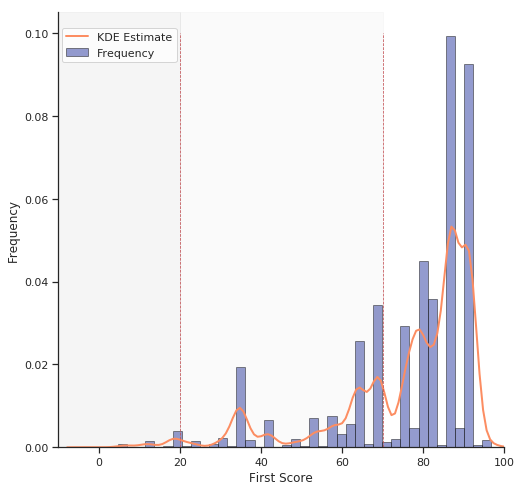

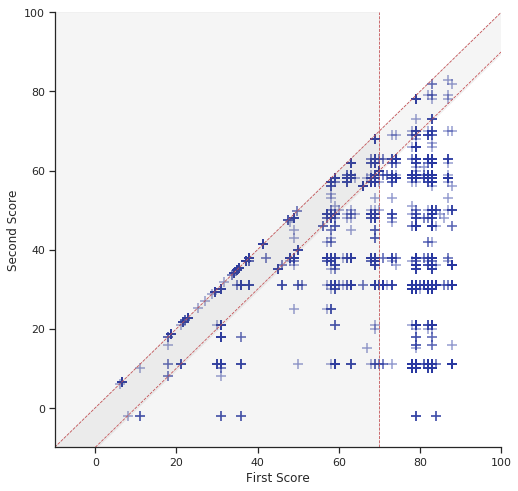

In [10]:
sns.set(style='ticks')
f, (ax1) = plt.subplots(1, 1, figsize=(8, 8))
h = sns.distplot(recon_sup[~pd.isnull(recon_sup['First Match'])]['First Score'],
                 bins=44,
                 kde_kws={"color": "#fc8d62",
                          "lw": 2, "label": "KDE Estimate",
                          "alpha": 1},
                 hist_kws={"color": "#2938a0",
                           "alpha": 0.5, "label": "Frequency",
                           'edgecolor': 'k'},
                 ax=ax1)
h.set(ylabel="Frequency")
h.set_xlim(xmin=-10, xmax=100)
h.plot([20, 20], [0, .1], color='r', linestyle='--', linewidth=0.75)
h.plot([70, 70], [0, .1], color='r', linestyle='--', linewidth=0.75)
h.legend(loc='center left', bbox_to_anchor=(-0.004, 0.925),frameon=True)
h.axvspan(-20, 20, alpha=0.08, color='grey')
h.axvspan(20, 70, alpha=0.04, color='grey')
sns.despine(right=True, top=True, ax=ax1)
f.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'mostmatch_and_safematch_a.pdf')),
          bbox_inches='tight')
f.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'mostmatch_and_safematch_a.png')), dpi=600, bbox_inches='tight')

f, (ax1) = plt.subplots(1, 1, figsize=(8, 8))
g = sns.regplot(x="First Score", y="Second Score", data=recon_sup,
                fit_reg=False, ax=ax1, color='#2938a0', marker='+',
                scatter_kws={'s':120, 'alpha':0.5})
g.set_xlim(xmin=-10, xmax=100)
g.set_ylim(ymin=-10, ymax=100)
r2 = patches.Rectangle((0, -20), 7.5, 200, color = "grey",  alpha=0.08)
t2 = mpl.transforms.Affine2D().rotate_deg(-45) + g.transData
r2.set_transform(t2)
g.add_patch(r2)
r1 = patches.Rectangle((70, -10), -80, 110, color="grey",  alpha=0.08)
g.add_patch(r1)
g.plot([-10, 100], [-10, 100], color='r', linestyle='--', linewidth=0.8)
g.plot([0, 100], [-10, 90], color='r', linestyle='--', linewidth=0.8)
g.plot([70, 70], [-10, 100], color='r', linestyle='--', linewidth=0.8)
sns.despine(right=True, top=True, ax=ax1)
f.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'mostmatch_and_safematch_b.pdf')), bbox_inches='tight')
f.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'mostmatch_and_safematch_b.png')), dpi=600,
          bbox_inches='tight')

### Section 5.2 Lets Evaluate our Matching Algorithm

Lets see exactly how our safematch algorithm performs. The denominators should match those above and those from ```evaluate_and_clean.py```

In [11]:
recon_clean = clean_matches(recon_sup, 'automated_safe')
recon_clean['company_number'] = recon_clean['Best ID'].str.replace('/companies/gb/','')
matched_clean = pd.merge(payments,
                         recon_clean,
                         how='left',
                         left_on='supplier_upper',
                         right_on='RawSupplier').dropna(subset=['Best Match'])
print('\nWe matched ' + str(len(matched_clean)) +
      ' out of ' + str(len(payments)) +
      ' payments in total (' + str(round(((len(matched_clean) /
                                           len(payments)) * 100), 2)) + '%).')
print('We matched £' + str(int(matched_clean['amount'].sum())) + ' out of ' +
      '£' + str(int(payments['amount'].sum())) +
      ' value in total (' + str(int(round(((matched_clean['amount'].sum() /
                                        payments['amount'].sum()) *
                                       100), 2))) + '%).')
print('We matched ' + str(len(matched_clean['supplier_upper'].unique())) +
      ' out of ' + str(len(payments['supplier_upper'].unique())) +
      ' unique suppliers in total (' +
      str(round(((len(matched_clean['supplier_upper'].unique()) /
                  len(payments['supplier_upper'].unique())) * 100), 2)) + '%).')

***Undertaking an automated safe reconciliation!***

We matched 340707 out of 852732 payments in total (39.95%).
We matched £172864351680 out of £1318291679121 value in total (13%).
We matched 13110 out of 42492 unique suppliers in total (30.85%).


## Section 6. Briefly Analyze Which Companies get What:

### Section 6.1 Tabulate Across Companies

In [12]:
sup_numpays = pd.DataFrame(matched_clean.groupby(
    ['Best Match']).size(), columns=['Number of Payments'])
sup_value = pd.DataFrame(pd.DataFrame(matched_clean.groupby(['Best Match'])[
                         'amount'].agg('sum'))).rename(
    columns={'amount': 'Value of Payments'})
sup_both = pd.concat([sup_value, sup_numpays], axis=1).reset_index()
recon_sup_for_match = recon_sup[['Best Match','Postcode','SIC Code','Type',
                                 'First Score',
                                 'Best ID']].drop_duplicates(subset='Best Match')
sup_both = pd.merge(sup_both, recon_sup_for_match, how='left',
                    left_on='Best Match', right_on='Best Match')
sup_both = sup_both.sort_values(ascending=False, by='Value of Payments')
sup_both['ID'] = sup_both['Best ID'].str.replace('/companies/gb/', '')
sup_both['Best Match'] = sup_both['Best Match'].str.title()
sup_both = sup_both.set_index('Best Match')
sup_both['SIC Code'] = sup_both['SIC Code'].str.replace("[", '')
sup_both['SIC Code'] = sup_both['SIC Code'].str.replace(']', '')
sup_both['SIC Code'] = sup_both['SIC Code'].str.replace("'", "")
sup_both[['Value of Payments', 'Number of Payments',
          'Postcode', 'SIC Code', 'Type']][0:20].style

,Value of Payments,Number of Payments,Postcode,SIC Code,Type
Best Match,,,,,
Student Loans Company Limited,2.80654e+10,72,DL1 1RW,64929,ltd
British Broadcasting Corporation,1.6104e+10,212,nan,nan,royal-charter
Post Office Limited,9.87999e+09,895,EC2Y 9AQ,"53100, 64999",ltd
Crossrail Limited,4.44847e+09,26,E14 5LQ,42120,ltd
Atos It Services Uk Limited,2.98883e+09,7526,WC1V 6EA,"26200, 62090, 70229, 86900",ltd
The Arts Council Of England,2.2796e+09,78,nan,nan,royal-charter
Ibm United Kingdom Limited,2.23665e+09,4925,PO6 3AU,26200,ltd
Connect Plus (M25) Limited,2.22203e+09,1041,EN6 3NP,42110,ltd
Aspire Defence Limited,2.12034e+09,445,SP9 7QD,68320,ltd


### 6.2 Split Across Departments:

In [13]:
depts_df = pd.DataFrame(columns=['Files', 'Spend (£m)', 'Total Payments',
                                 '% to Prviate', 'Most Frequent PS Supplier'],
                        index=payments['dept'].unique())
for dept in matched_clean[matched_clean['dept'].notnull()]['dept'].unique():
    depts_df.loc[dept, 'Files'] = len(payments[payments['dept'] ==
                                               dept]['file'].unique())
    depts_df.loc[dept, 'Spend (£m)'] = round(
        payments[payments['dept'] == dept]['amount'].sum() / 1000000, 2)
    depts_df.loc[dept, 'Total Payments'] = len(
        payments[payments['dept'] == dept])
    depts_df.loc[dept,
                 'Most Frequent PS Supplier'] = matched_clean[matched_clean['dept']
                                                      == dept]['Best Match'].\
    value_counts().sort_values(ascending=False).index[0]
    depts_df.loc[dept, '% to Prviate'] = round((matched_clean[matched_clean['dept'] ==
                                                        dept]['amount'].sum(
    ) / payments[payments['dept'] == dept]['amount'].sum()) * 100, 2)

### 6.3 Across SIC categories

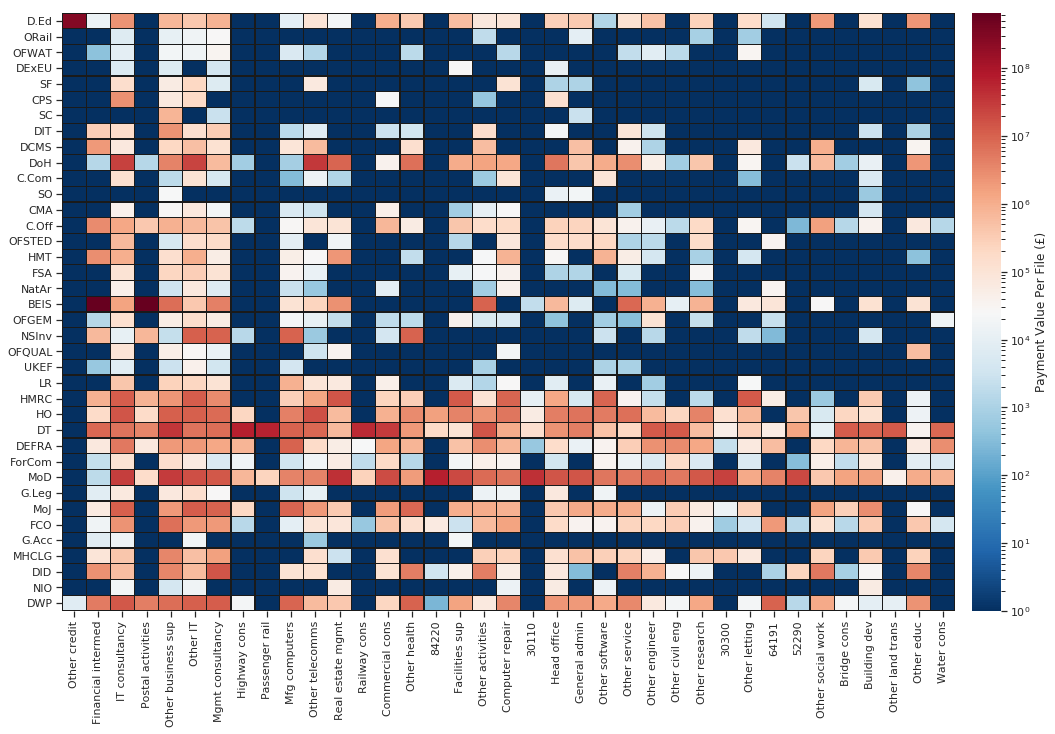

In [14]:
with open(os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'output',
                 'master', 'Single_SICs.tsv')), 'w') as sicfile:
    sicfile.write('amount\tdept\tsic\n')
    for index, row in matched_clean.iterrows():
        if pd.isnull(row['SIC Code']) is False:
            for sic in row['SIC Code'].split(','):
                sic = re.findall('\\b\\d+\\b', sic)[0]
                sicfile.write(str(row['amount']) + '\t' + 
                              str(row['dept']) + '\t' + str(sic)+'\n')
sicfile = pd.read_csv(os.path.abspath(
                      os.path.join('__file__', '../..',
                                   'data', 'output', 'master',
                                   'Single_SICs.tsv')),
                      sep = '\t', encoding='latin-1')
sicfile = sicfile[sicfile['amount']>25000]
replacedict = pd.read_csv((os.path.abspath(
                           os.path.join('__file__', '../..', 'data',
                                        'support', 'sic_renamer.csv'))),
                          header=None,
                          dtype={0: str}).set_index(0).squeeze().to_dict()
for key, value in replacedict.items():
    sicfile['sic'] = sicfile['sic'].replace(int(key),value)
sup_value = pd.DataFrame(pd.DataFrame(matched_clean.\
                                      groupby(['Best Match'])['amount'].agg('sum')))
uniquedepts = sicfile['dept'].unique()
top_sics = pd.DataFrame(sicfile.groupby(['sic'])['amount'].\
                        agg('sum')).sort_values(by='amount',
                                                ascending=False)[0:37].index
sicdept_df = pd.DataFrame(columns = top_sics, index = uniquedepts)
for dept in uniquedepts:
    for sic in list(sicdept_df):
        sicdept_df.loc[dept,sic] = (sicfile[(sicfile['sic']==sic) &
                                            (sicfile['dept']==dept)]['amount'].sum()/
                                    depts_df.loc[dept,'Files'])
fig, ax = plt.subplots(figsize=(16,11))
sicdept_df=sicdept_df.astype(float)
sicdept_df[sicdept_df <= 0] = 1
log_norm = LogNorm(vmin=sicdept_df.min().min(),
                   vmax=sicdept_df.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(sicdept_df.min().min())),
                                             1+math.ceil(math.log10(sicdept_df.max().max())))]
cbar_ax = fig.add_axes([.915, 0.125, .025, .755])
g = sns.heatmap(sicdept_df,
                linewidths=0.25,
                linecolor='k',
                cmap="RdBu_r",
                cbar_ax = cbar_ax,
                ax = ax,
                norm=log_norm,
                cbar_kws={'ticks': cbar_ticks,
                          'label': 'Payment Value Per File (£)'})
g.set_ylabel('');
g.set_xlabel('');
fig = g.get_figure()
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'sic_dept_heatmap.pdf')), bbox_inches='tight')
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'sic_dept_heatmap.png')), dpi=600, bbox_inches='tight')

## Section 7. Sociological Stratification of Officers and PSCs

Lets first load the supplementary CH data on Officers and Persons of Signifciant Control (PSCs). Because the files are quite large, only load the datasets which we are actually going to use (i.e. ```usecols```):

In [15]:
ch_psc = pd.read_csv(os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'companies_house',
                 'psc_flatfile.tsv')),
    encoding="ISO-8859-1", sep='\t', error_bad_lines=False,
                    dtype={'company_number': str,
                           'name':str,
                           'nationality':str,
                           'forename': str,
                           'date_of_birth':object,
                           'country_of_residence':str},
                    usecols=['company_number',
                             'date_of_birth',
                             'name',
                             'nationality',
                             'country_of_residence',
                             'forename'])
ch_officers = pd.read_csv(os.path.abspath(
    os.path.join('__file__', '../..', 'data', 'companies_house',
                 'ch_full_officers.tsv')),
    encoding="ISO-8859-1", sep='\t', error_bad_lines=False, 
                          warn_bad_lines = False,
                dtype={'CompanyNumber': str,
                       'Name': str,
                       'Officer Role': str,
                       'Occupation':str,
                       'Resigned': str,
                       'Appointed': str,
                       'Nationality':str,
                       'Country of Residence':str},
                usecols = ['CompanyNumber',
                           'Name',
                           'Resigned',
                           'Appointed',
                           'Officer Role',
                           'Nationality',
                           'Date of Birth',
                           'Occupation',
                           'Country of Residence'])

### Section 7.1 Compare Officer and PSC Age in CH and the Subset of ```centgovspend``` Procurers

Lets first visualise the age distribution of officers and PSCs between the entire CH and the subset which is supplying central government:

In [16]:
ch_officers_age = ch_officers[ch_officers['Date of Birth'].notnull()]
ch_officers_age = ch_officers_age[ch_officers_age['Date of Birth'].str.contains('year')]
ch_officers_age_uni = pd.DataFrame(ch_officers_age['Date of Birth'].drop_duplicates(),
                                   columns=['Date of Birth'])
ch_officers_age_uni['Evaluated Date'] = ch_officers_age_uni['Date of Birth'].apply(lambda x: dict(eval(x)))
ch_officers_age_uni = pd.merge(ch_officers_age_uni['Evaluated Date'].apply(pd.Series),
                                      ch_officers_age_uni,left_index=True,right_index=True)
ch_officers_age = pd.merge(ch_officers_age, ch_officers_age_uni, left_on='Date of Birth',
                          right_on='Date of Birth',how='left')
ch_officers_age = ch_officers_age[(ch_officers_age['year'] >= 1900)
                          & (ch_officers_age['year'] <= 2018)]
ch_officers_age['Cleaned Date'] = ch_officers_age['year'].map(
    str) + '-' + ch_officers_age['month'].map(str) + '-01'
ch_officers_age['Age'] = pd.to_datetime(
    'today').year - pd.to_datetime(ch_officers_age['Cleaned Date']).dt.year
ch_officers_age = ch_officers_age[ch_officers_age['Age'].notnull()]
ch_officers_age = ch_officers_age[ch_officers_age['Age']>0]
ch_officers_age = ch_officers_age[ch_officers_age['Age']<=100]                  
recon_officers_age = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_officers_age, how='left', left_on='company_number',
                                right_on='CompanyNumber')
recon_officers_age = recon_officers_age[recon_officers_age['Age'].notnull()]

In [17]:
ch_psc_age = ch_psc[ch_psc['date_of_birth'].notnull()]
ch_psc_age_uni = pd.DataFrame(ch_psc_age['date_of_birth'].drop_duplicates(),columns=['date_of_birth'])
ch_psc_age_uni['Evaluated Date'] = ch_psc_age_uni['date_of_birth'].apply(lambda x: dict(eval(x)))
ch_psc_age_uni = pd.merge(ch_psc_age_uni['Evaluated Date'].apply(pd.Series),
                          ch_psc_age_uni,left_index=True,right_index=True)
ch_psc_age = pd.merge(ch_psc_age, ch_psc_age_uni, left_on='date_of_birth',
                          right_on='date_of_birth',how='left')
ch_psc_age = ch_psc_age[(ch_psc_age['year'] >= 1900)
                          & (ch_psc_age['year'] <= 2018)]
ch_psc_age['Cleaned Date'] = ch_psc_age['year'].map(
    str) + '-' + ch_psc_age['month'].map(str) + '-01'
ch_psc_age['Age'] = pd.to_datetime(
    'today').year - pd.to_datetime(ch_psc_age['Cleaned Date']).dt.year
#ch_psc_age = ch_psc_age[ch_psc_age['Age'].notnull()]
#ch_psc_age = ch_psc_age[ch_psc_age['Age']>0]
#ch_psc_age = ch_psc_age[ch_psc_age['Age']<=100]
recon_psc_age = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_psc_age, how='left', left_on='company_number',
                                right_on='company_number')
recon_psc_age = recon_psc_age[recon_psc_age['Age'].notnull()]

In [18]:
ch_psc_age_filtered = ch_psc_age[(0<=ch_psc_age['Age']) &
                                 (ch_psc_age['Age']<100)]['Age']
recon_psc_age_filtered = recon_psc_age[(0<=recon_psc_age['Age']) &
                                    (recon_psc_age['Age']<100)]['Age']
ch_officers_age_filtered = ch_officers_age[(0<=ch_officers_age['Age']) &
                                                  (ch_officers_age['Age']<100)]['Age']
recon_officers_age_filtered = recon_officers_age[(0<=recon_officers_age['Age']) &
                                                        (recon_officers_age['Age']<100)]['Age']

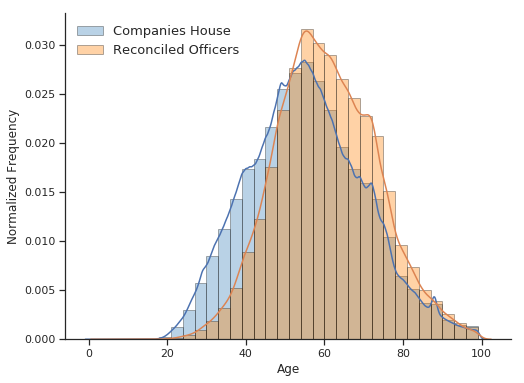

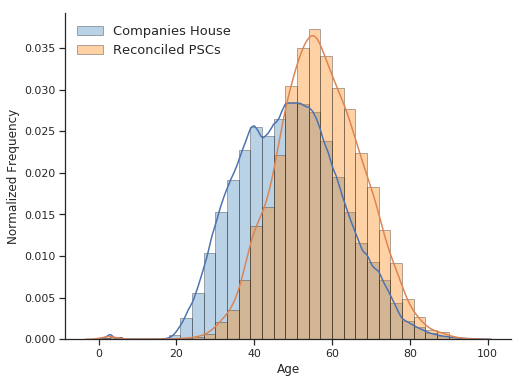

In [19]:
sns.set(style='ticks')
f, (ax1) = plt.subplots(1, 1, figsize=(8,6))
g = sns.distplot(ch_officers_age_filtered,
                 ax=ax1,
                 kde_kws={'gridsize':500},
                 hist_kws={'color':'#377eb8', 'alpha':0.35, 'edgecolor':'k'},
                 label = 'Companies House',
                 bins=np.arange(0, 100, 3))
g = sns.distplot(recon_officers_age_filtered,
                 ax=ax1,
                 kde_kws={'gridsize':500},
                 hist_kws={'color':'#ff7f00', 'alpha':0.35, 'edgecolor':'k'},
                 label = 'Reconciled Officers',
                 bins=np.arange(0, 100, 3))
ax1.set_ylabel("Normalized Frequency",fontsize=12)
ax1.set_xlabel("Age",fontsize=12)
sns.despine()
g.legend(loc='upper left',edgecolor='k',frameon=False, fontsize=13)
f.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'officers_age.pdf')), bbox_inches='tight')
f.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'officers_age.png')), dpi=600, bbox_inches='tight')

f, (ax1) = plt.subplots(1, 1, figsize=(8,6))
g = sns.distplot(ch_psc_age_filtered, ax=ax1,
                 kde_kws={'gridsize':500},
                 hist_kws={'color':'#377eb8', 'alpha':0.35, 'edgecolor':'k'},
                 label = 'Companies House',
                 bins=np.arange(0, 100, 3))
g = sns.distplot(recon_psc_age_filtered, ax=ax1,
                 kde_kws={'gridsize':500},
                 hist_kws={'color':'#ff7f00', 'alpha':0.35, 'edgecolor':'k'},
                 label = 'Reconciled PSCs',
                 bins=np.arange(0, 100, 3))
ax1.set_ylabel("Normalized Frequency",fontsize=12)
ax1.set_xlabel("Age",fontsize=12)
sns.despine()
g.legend(loc='upper left',edgecolor='k',frameon=False, fontsize=13)
f.savefig(os.path.abspath(os.path.join('__file__', '../..','compile','figures',
                                       'psc_age.pdf')), bbox_inches='tight')
f.savefig(os.path.abspath(os.path.join('__file__', '../..','compile','figures',
                                       'psc_age.png')), dpi=600, bbox_inches='tight')

In [20]:
print('The average age of Companies House officers is ' + 
      str(round(ch_officers_age['Age'].mean(),2)) + ' years.')
print('The average age of officers in government supplying companies is ' + 
      str(round(recon_officers_age['Age'].mean(),2)) + ' years.')
print('The average age of Companies House PSC is ' + 
      str(round(ch_psc_age['Age'].mean(),2)) + ' years.')
print('The average age of PSC in government supplying companies is ' + 
      str(round(recon_psc_age['Age'].mean(),2)) + ' years.')

The average age of Companies House officers is 55.4 years.
The average age of officers in government supplying companies is 60.52 years.
The average age of Companies House PSC is 49.13 years.
The average age of PSC in government supplying companies is 56.73 years.


### Section 7.2 Compare Officer and PSC Gender in CH and the Subset of ```centgovspend``` Procurers

In [21]:
ch_officers_gen = ch_officers.copy()
ch_officers_gen = ch_officers_gen[ch_officers_gen['Name'].notnull()]
ch_officers_gen.loc[:,'Forename'] = ch_officers_gen['Name'].apply(
    lambda x: clean_officer_names(x))
ch_officers_gen.loc[:,'CleanGender'] = ch_officers_gen['Forename'].apply(
    lambda x: gendet.get_gender(x))
ch_officers_gen.loc[:,'MaleFemale'] = ch_officers_gen['CleanGender'].str.replace(
    'mostly_', '')
ch_officers_gen.loc[:,'isfemale'] = np.where(
    ch_officers_gen['MaleFemale'] == 'female', 1, 0)
ch_officers_gen = ch_officers_gen[(ch_officers_gen['MaleFemale'] == 'male') | (
    ch_officers_gen['MaleFemale'] == 'female')]
recon_officers_gen = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_officers_gen, how='left', left_on='company_number',
                                right_on='CompanyNumber')
recon_officers_gen = recon_officers_gen[(recon_officers_gen['MaleFemale'] == 'male') | (
    recon_officers_gen['MaleFemale'] == 'female')]

print('The percent of female officers in CH in total is: ' +
      str(round(ch_officers_gen['isfemale'].mean()*100,2)) + '%.')
print('The percent of female officers in companioes supplying the government is: ' +
      str(round(recon_officers_gen['isfemale'].mean()*100,2)) + '%.')

The percent of female officers in CH in total is: 29.44%.
The percent of female officers in companioes supplying the government is: 27.91%.


In [22]:
ch_psc_gen = ch_psc.copy()
ch_psc_gen = ch_psc_gen[ch_psc_gen['forename'].notnull()]
ch_psc_gen.loc[:,'CleanGender'] = ch_psc_gen['forename'].apply(
    lambda x: gendet.get_gender(x))
ch_psc_gen['MaleFemale'] = ch_psc_gen['CleanGender'].str.replace(
    'mostly_', '')
ch_psc_gen['isfemale'] = np.where(
    ch_psc_gen['MaleFemale'] == 'female', 1, 0)
ch_psc_gen = ch_psc_gen[(ch_psc_gen['MaleFemale'] == 'male') | (
    ch_psc_gen['MaleFemale'] == 'female')]

recon_psc_gen = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_psc_gen, how='left', left_on='company_number',
                                right_on='company_number')
recon_psc_gen = recon_psc_gen[(recon_psc_gen['MaleFemale'] == 'male') | (
    recon_psc_gen['MaleFemale'] == 'female')]

print('The percent of female PSC in CH in total is: ' +
      str(round(ch_psc_gen['isfemale'].mean()*100, 4)) + '%.')
print('The percent of female PSC in the subset of companies supplying the government is: ' +
      str(round(recon_officers_gen['isfemale'].mean()*100,2)) + '%.')

The percent of female PSC in CH in total is: 27.7811%.
The percent of female PSC in the subset of companies supplying the government is: 27.91%.


### Section 7.3 Compare Officer and PSC Nationality and Country of Residence in CH and the Subset of ```centgovspend``` Procurers

First do the nationalities:

In [23]:
ch_psc_nat = ch_psc.copy()
ch_psc_nat = ch_psc_nat[ch_psc_nat['nationality'].notnull()]
ch_psc_nat.loc[:,'nationality'] = ch_psc_nat['nationality'].apply(lambda x:
                                                                  clean_nationalities(x))
len_ch_psc_nat = len(ch_psc_nat[ch_psc_nat['nationality'].notnull()])
ch_psc_nat_pcs = ch_psc_nat['nationality'].value_counts().divide(len_ch_psc_nat/100)
ch_psc_nat_pcs = ch_psc_nat_pcs.sort_values(ascending=False)

recon_psc_nat = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_psc_nat, how='left', left_on='company_number',
                                right_on='company_number')
recon_psc_nat = recon_psc_nat[recon_psc_nat['nationality'].notnull()]
recon_psc_nat['nationality'] = recon_psc_nat['nationality'].map(lambda x:
                                                                clean_nationalities(x))
len_recon_psc_nat = len(recon_psc_nat[recon_psc_nat['nationality'].notnull()])
recon_psc_nat_pcs = recon_psc_nat['nationality'].value_counts().\
                    divide(len_recon_psc_nat/100)
recon_psc_nat_pcs = recon_psc_nat_pcs.sort_values(ascending=False)

In [24]:
ch_officers_nat = ch_officers.copy()
ch_officers_nat = ch_officers_nat[ch_officers_nat['Nationality'].notnull()]
ch_officers_nat['Nationality'] = ch_officers_nat['Nationality'].map(lambda x:
                                                                    clean_nationalities(x))
len_ch_officers_nat = len(ch_officers_nat[ch_officers_nat['Nationality'].notnull()])
ch_officers_nat_pcs = ch_officers_nat['Nationality'].value_counts().\
                      divide(len_ch_officers_nat/100)
ch_officers_nat_pcs = ch_officers_nat_pcs.sort_values(ascending=False)

recon_officers_nat = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_officers_nat, how='left', left_on='company_number',
                                right_on='CompanyNumber')
recon_officers_nat = recon_officers_nat[recon_officers_nat['Nationality'].notnull()]
recon_officers_nat['Nationality'] = recon_officers_nat['Nationality'].map(lambda x:
                                                                          clean_nationalities(x))
len_recon_officers_nat = len(recon_officers_nat[recon_officers_nat['Nationality'].notnull()])
recon_officers_nat_pcs = recon_officers_nat['Nationality'].value_counts().\
                         divide(len_recon_officers_nat/100)
recon_officers_nat_pcs = recon_officers_nat_pcs.sort_values(ascending=False)

Then do the country of residences:

In [25]:
ch_psc_cou = ch_psc.copy()
ch_psc_cou = ch_psc_cou[ch_psc_cou['country_of_residence'].notnull()]
ch_psc_cou['country_of_residence'] = ch_psc_cou['country_of_residence'].\
                                     map(lambda x: clean_countries(x))
len_ch_psc_cou = len(ch_psc_cou[ch_psc_cou['country_of_residence'].notnull()])
ch_psc_cou_pcs = ch_psc_cou['country_of_residence'].\
                 value_counts().divide(len_ch_psc_cou/100)
ch_psc_cou_pcs = ch_psc_cou_pcs.sort_values(ascending=False)
recon_psc_cou = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                      ch_psc_cou, how='left', left_on='company_number',
                                      right_on='company_number')
recon_psc_cou = recon_psc_cou[recon_psc_cou['country_of_residence'].notnull()]
len_recon_psc_cou = len(recon_psc_cou[recon_psc_cou['country_of_residence'].notnull()])
recon_psc_cou_pcs = recon_psc_cou['country_of_residence'].\
                    value_counts().divide(len_recon_psc_cou/100)
recon_psc_cou_pcs = recon_psc_cou_pcs.sort_values(ascending=False)

In [26]:
ch_officers_cou = ch_officers.copy()
ch_officers_cou = ch_officers_cou[ch_officers_cou['Country of Residence'].notnull()]
ch_officers_cou['Country of Residence'] = ch_officers_cou['Country of Residence'].\
                                          apply(lambda x: clean_countries(x))
len_ch_officers_cou = len(ch_officers_cou[ch_officers_cou['Country of Residence'].notnull()])
ch_officers_cou_pcs = ch_officers_cou['Country of Residence'].\
                      value_counts().divide(len_ch_officers_cou/100)
ch_officers_cou_pcs = ch_officers_cou_pcs.sort_values(ascending=False)
recon_officers_cou = pd.merge(pd.DataFrame(recon_clean['company_number'].drop_duplicates()),
                                ch_officers_cou, how='left', left_on='company_number',
                                right_on='CompanyNumber')
recon_officers_cou = recon_officers_cou[recon_officers_cou['Country of Residence'].
                                        notnull()]
len_recon_officers_cou = len(recon_officers_cou[recon_officers_cou['Country of Residence'].
                                                notnull()])
recon_officers_cou_pcs = recon_officers_cou['Country of Residence'].\
                         value_counts().divide(len_recon_officers_cou/100)
recon_officers_cou_pcs = recon_officers_cou_pcs.sort_values(ascending=False)

Lets plot this as a figure:

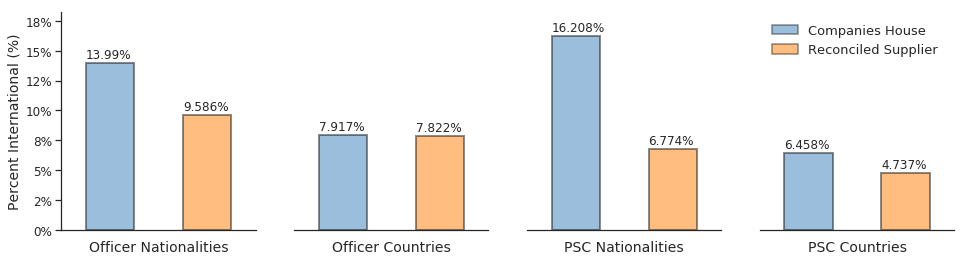

In [27]:
df_resi_nat = pd.DataFrame(index=['CH','Recon'],
                           columns=['Officer Countries', 'Officer Nationalities',
                                    'PSC Countries', 'PSC Nationalities'])
df_resi_nat.loc['Recon','Officer Countries'] = 100-recon_officers_cou_pcs['United Kingdom']
df_resi_nat.loc['CH','Officer Countries'] = 100-ch_officers_cou_pcs['United Kingdom']
df_resi_nat.loc['Recon','PSC Countries'] = 100-recon_psc_cou_pcs['United Kingdom']
df_resi_nat.loc['CH','PSC Countries'] = 100-ch_psc_cou_pcs['United Kingdom']
df_resi_nat.loc['Recon','Officer Nationalities'] = 100-recon_officers_nat_pcs['British']
df_resi_nat.loc['CH','Officer Nationalities'] = 100-ch_officers_nat_pcs['British']
df_resi_nat.loc['Recon','PSC Nationalities'] = 100-recon_psc_nat_pcs['British']
df_resi_nat.loc['CH','PSC Nationalities'] = 100-ch_psc_nat_pcs['British']
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(16,4))
sns.set_style("ticks")
a = df_resi_nat['Officer Nationalities'].plot(kind='bar', ax=axes[0],
                                              color=['#377eb8','#ff7f00'],
                                              alpha=0.5, edgecolor='k',
                                              linewidth=2)
b = df_resi_nat['Officer Countries'].plot(kind='bar', ax=axes[1],
                                          color=['#377eb8','#ff7f00'],
                                          alpha=0.5, edgecolor='k',
                                          linewidth=2)
c = df_resi_nat['PSC Nationalities'].plot(kind='bar', ax=axes[2], 
                                          color=['#377eb8','#ff7f00'],
                                          alpha=0.5, edgecolor='k',
                                          linewidth=2)
d = df_resi_nat['PSC Countries'].plot(kind='bar', ax=axes[3],
                                      color=['#377eb8','#ff7f00'],
                                      alpha=0.5, edgecolor='k',
                                      linewidth=2, legend=True)
CH = patches.Patch(facecolor='#377eb8', label='Companies House',
                   alpha=0.5,edgecolor='k',linewidth=1.5)
Recon = patches.Patch(facecolor='#ff7f00', label='Reconciled Supplier',
                      alpha=0.5,edgecolor='k',linewidth=1.5)
plt.legend(handles=[CH,Recon], loc=2,fontsize=13, edgecolor='k',
           frameon=False)

a.set_xlabel("Officer Nationalities",fontsize=14,labelpad=10)
b.set_xlabel("Officer Countries",fontsize=14,labelpad=10)
c.set_xlabel("PSC Nationalities",fontsize=14,labelpad=10)
d.set_xlabel("PSC Countries",fontsize=14,labelpad=10)

for axy in [a,b,c,d]:
    axy.set_ylim(0, df_resi_nat.max().max()+2)
    axy.axes.get_xaxis().set_ticks([])
    for p in axy.patches:
        axy.annotate(str(round(p.get_height(),3))+'%', (p.get_x(), p.get_height() + 0.4))
    if axy!=a:
        sns.despine(ax=axy, left=True, bottom = False, right = True)
        axy.axes.get_yaxis().set_visible(False)
    else:
        sns.despine(ax=axy, left=False, bottom = False, right = True)
        axy.set_ylabel("Percent International (%)",fontsize=14)
        vals = axy.get_yticks()
        axy.set_yticklabels(['{:,.0%}'.format(x/100) for x in vals],fontsize=12)

fig.subplots_adjust(hspace=25)
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'countries_and_nationalities.pdf')),
            bbox_inches='tight')
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'countries_and_nationalities.png')),
            dpi=600, bbox_inches='tight')

### Section 7.4 Compare Officer Occupations in CH and the Subset of ```centgovspend``` Procurers

Not included in the paper, but lets look at the occupations of the Officers:

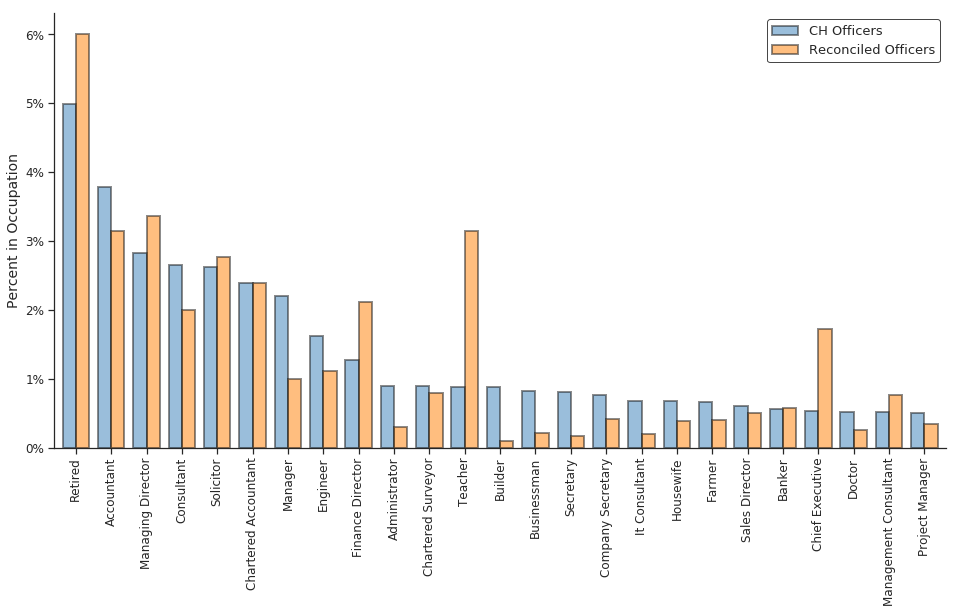

In [28]:
ch_officers_occ = ch_officers[ch_officers['Occupation'].notnull()]
ch_officers_occ = ch_officers_occ[ch_officers_occ['Occupation']!='Director']
ch_officers_occ = ch_officers_occ[ch_officers_occ['Occupation']!='Company Director']
ch_officers_occ = ch_officers_occ[ch_officers_occ['Occupation']!='None']
ch_officers_occ['Occupation'] = ch_officers_occ['Occupation'].map(lambda x:
                                                                  clean_occupations(x))
len_ch_officers_occ = len(ch_officers_occ[ch_officers_occ['Occupation'].notnull()])
ch_officers_occ_pcs = ch_officers_occ['Occupation'].value_counts().\
                      divide(len_ch_officers_occ/100)
ch_officers_occ_pcs = ch_officers_occ_pcs.\
                      sort_values(ascending=False)
recon_officers_occ = pd.merge(pd.DataFrame(recon_clean['company_number'].\
                                           drop_duplicates()),
                                ch_officers_occ, how='left', left_on='company_number',
                                right_on='CompanyNumber')
len_recon_officers_occ = len(recon_officers_occ[recon_officers_occ['Occupation'].notnull()])
recon_officers_occ_pcs = recon_officers_occ['Occupation'].\
                         value_counts().divide(len_recon_officers_occ/100)
recon_officers_occ_pcs = recon_officers_occ_pcs.sort_values(ascending=False)

both_officers_occ_pcs = pd.merge(pd.DataFrame(ch_officers_occ_pcs),
                                 pd.DataFrame(recon_officers_occ_pcs),
                                 left_index=True, right_index=True)
both_officers_occ_pcs = both_officers_occ_pcs.rename({'Occupation_x': 'CH Officers',
                                                      'Occupation_y': 'Reconciled Officers'},
                                                     axis=1)
sns.set_style("ticks")
a = both_officers_occ_pcs[0:25].plot(kind='bar', figsize=(16,8),
                                     color=['#377eb8','#ff7f00'],
                                     alpha=0.5, edgecolor='k',
                                     width=0.75, linewidth=2)
a.set_ylabel("Percent in Occupation", fontsize=14)
vals = a.get_yticks()
a.set_yticklabels(['{:,.0%}'.format(x/100) for x in vals], fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(loc='upper right',fontsize=13, edgecolor='k')
sns.despine()
fig = a.get_figure()
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'officer_occupations.pdf')), bbox_inches='tight')
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'officer_occupations.png')), dpi=600, bbox_inches='tight')

In [29]:
payments[payments['dept']=='HHO']['file'].drop_duplicates().sort_values()

Series([], Name: file, dtype: object)

In [30]:
payments[(payments['dept']=='HHO') &
         (payments['file'].str.contains('february-2011'))].sort_values(by='amount').drop_duplicates()

,date,expensetype,expensearea,supplier,transactionnumber,amount,file,dept,supplier_upper


In [31]:
payments[(payments['dept']=='HHO') &
         (payments['file'].str.contains('february-2011'))].sort_values(by='amount').drop_duplicates(subset=['transactionnumber',
                                                                                                            'amount',
                                                                                                            'supplier',
                                                                                                            'date',
                                                                                                            'expensearea',
                                                                                                            'expensetype'])

,date,expensetype,expensearea,supplier,transactionnumber,amount,file,dept,supplier_upper


In [32]:
payments.loc[626585:626585]['date']

626585   2018-09-07
Name: date, dtype: datetime64[ns]

In [33]:
payments.loc[627586:627586]['date']

627586   2013-10-23
Name: date, dtype: datetime64[ns]

## Section 8: Network Analysis

Lets analyze the network using two common packages: Networkit and Network-X.

### Section 8.1: Networkit

#### Section 8.1.1 Networkit Overviews

In [34]:
ch_officers = add_datetimes(ch_officers)
ch_officers['New_ID'] = ch_officers['Name'] + '@ ' +\
                        ch_officers['Date of Birth'].astype(str)
ch_off_in_reconclean = pd.merge(recon_clean[['company_number']],
                                ch_officers[['CompanyNumber','Appointed_DT',
                                             'Resigned_DT','New_ID']],
                                how='left',
                                left_on='company_number',
                                right_on='CompanyNumber')
seper = ';'
edge_set, company_set, officer_set  = make_edgelist(ch_off_in_reconclean,
                                                    2017,
                                                    os.path.abspath(
                                                    os.path.join('__file__',
                                                                 '../..',
                                                                 'data',
                                                                 'companies_house',
                                                                 'network_file.txt')),
                                                   seper)

100%|██████████| 5714/5714 [00:00<00:00, 1308773.10it/s]


In [35]:
nodeData = pd.read_csv(os.path.abspath(os.path.join('__file__',
                                                    '../..',
                                                    'data',
                                                    'companies_house',
                                                    'network_file.txt')),
                      sep=';',names=['edge1','edge2'])
nodeData = pd.DataFrame(list(set(nodeData['edge1'].tolist() +
                                nodeData['edge2'].tolist()))).\
                        rename({0:'node'}, axis=1)
nodeIds = {row[1].node:row[0] for row in nodeData.iterrows()}
Entire = networkit.graph.Graph(len(nodeData))
with open(os.path.abspath(os.path.join('__file__',
                                       '../..',
                                       'data',
                                       'companies_house',
                                       'network_file.txt'))) as f:
    for line in tqdm(f):
        if not line.startswith('#') and line.strip():
            splitLine = line.strip().split(";")
            sourceId = nodeIds.get(splitLine[0], None)
            targetId = nodeIds.get(splitLine[1], None)
            if sourceId != None and targetId != None:
                Entire.addEdge(sourceId, targetId)
overview(Entire)

5714it [00:00, 434045.44it/s]

Network Properties for:		G#3
nodes, edges			3298, 5714
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.001051
clustering coefficient		0.343817
min/max/avg degree		1, 43, 3.465130
degree assortativity		0.986339
number of connected components	955
size of largest component	183 (5.55 %)


In [36]:
communities = community.detectCommunities(Entire, inspect=True)

PLM(balanced,pc,turbo) detected communities in 0.010589599609375 [s]
solution properties:
-------------------  ----------
# communities        967
min community size     2
max community size    61
avg. community size    3.41055
modularity             0.956853
-------------------  ----------


In [37]:
component_size_count = pd.DataFrame((v for v in list(components.ConnectedComponents(Entire).\
                                                run().getComponentSizes().values())),
                                columns=['componentsize'])
component_size_count.groupby('componentsize')['componentsize'].count()[:5]

componentsize
2    605
3    185
4     73
5     22
6     18
Name: componentsize, dtype: int64

In [38]:
Giant = workflows.extractLargestComponent(Entire)
overview(Giant)

INFO:root:extracting component 15 containing 183 nodes


Network Properties for:		G#20
nodes, edges			183, 746
directed?			False
weighted?			False
isolated nodes			3115
self-loops			0
density				0.044797
clustering coefficient		0.667379
min/max/avg degree		0, 26, 8.153005
degree assortativity		0.864432
number of connected components	1
size of largest component	183 (100.00 %)


#### Section 8.1.2 Networkit Visualizations

Just for completeness

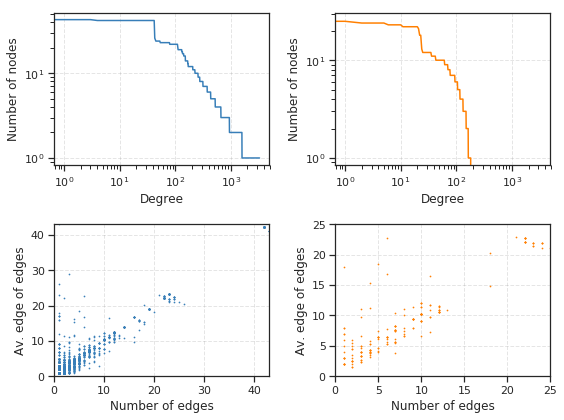

In [39]:
fig = plt.figure(figsize=(8, 6))
plt.figure(1)
plt.subplot(221)
dd = sorted(centrality.DegreeCentrality(Entire).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("Degree")
plt.yscale("log")
plt.ylabel("Number of nodes")
plt.plot(dd, color='#377eb8')
plt.grid(alpha=0.2, color='grey', linestyle='--')

plt.subplot(222)
dd = sorted(centrality.DegreeCentrality(Giant).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("Degree")
plt.yscale("log")
plt.ylabel("Number of nodes")
plt.plot(dd, color='#ff7f00')
plt.grid(alpha=0.2, color='grey', linestyle='--')

plt.subplot(223)
maxDeg = sorted(centrality.DegreeCentrality(Entire).run().scores(),
                reverse=True)[1]
plt.xlim(0, maxDeg)
plt.ylim(0, maxDeg)
plt.xlabel("Number of edges")
plt.ylabel("Av. edge of edges")
plt.scatter(x=[Entire.degree(v) for v in Entire.nodes()],
            y=[avgFriendDegree(v, Entire) for v in Entire.nodes()],
            s=0.5,color='#377eb8')
plt.grid(alpha=0.2, color='grey', linestyle='--')

plt.subplot(224)
maxDeg = sorted(centrality.DegreeCentrality(Giant).run().scores(),reverse=True)[1]
plt.xlim(0, maxDeg)
plt.ylim(0, maxDeg)
plt.xlabel("Number of edges")
plt.ylabel("Av. edge of edges")
plt.scatter(x=[Giant.degree(v) for v in Giant.nodes()],
            y=[avgFriendDegree(v, Giant) for v in Giant.nodes()],
            s=0.5, color='#ff7f00')
plt.grid(alpha=0.2, color='grey', linestyle='--')
plt.tight_layout()
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'network_plot.pdf')), bbox_inches='tight')
fig.savefig(os.path.abspath(
    os.path.join('__file__', '../..','compile','figures',
                 'network_plot.png')), dpi=600, bbox_inches='tight')
plt.show()

### 8.2 Network-X

In [40]:
G=nx.Graph()
seper=' '
ch_off_in_reconclean = ch_off_in_reconclean[ch_off_in_reconclean['New_ID'] != 'N\\A']
ch_off_in_reconclean = ch_off_in_reconclean[(2017 >
                ch_off_in_reconclean['Appointed_DT'].dt.year) &
                ((2017 <= ch_off_in_reconclean['Resigned_DT'].dt.year) |
                (ch_off_in_reconclean['Resigned_DT'].dt.year).isnull())]
only_essentials = ch_off_in_reconclean[['CompanyNumber', 'New_ID']]
edge_df = pd.DataFrame(only_essentials.
                       groupby('New_ID')['CompanyNumber'].
                       apply(lambda x: list(itertools.combinations(x, 2))))
edge_df[edge_df['CompanyNumber'].apply(len) > 0]
officer_set = set(edge_df.index)
set_of_edges = set()
company_set = set()
list_for_count = []
for toople in tqdm(edge_df['CompanyNumber'].tolist()):
    for pair in toople:
        company_set.add(pair[0])
        company_set.add(pair[1])
        list_for_count.append(pair[0])
        list_for_count.append(pair[1])
        if (pair[0] + seper + pair[1] not in set_of_edges) and\
           (pair[1] + seper + pair[0] not in set_of_edges) and\
           (pair[1] != pair[0]):
            set_of_edges.add(pair[0] + seper + pair[1])
            G.add_edge(pair[1],pair[0])

100%|██████████| 73677/73677 [00:00<00:00, 876444.28it/s]


In [41]:
edge_counter = pd.DataFrame(dict(Counters=Counter(list_for_count))).\
               sort_values(by='Counters',
                           ascending=False).reset_index().\
               rename({'index':'company_number'}, axis=1)
counter_merged = pd.merge(edge_counter,
                          sup_both.reset_index().\
                          rename({'Best Match':'company_name'},
                                 axis=1)[['Value of Payments',
                                          'Number of Payments',
                                          'ID', 'company_name']],
                          how='left', left_on='company_number',
                          right_on='ID').drop('ID', axis=1)
counter_merged = counter_merged.rename({'company_number': 'Company Number',
                                        'company_name': 'Company Name',
                                        'Counters': 'Edges (#)',
                                        'Value of Payments': 'Payments (£)',
                                        'Number of Payments': 'Payments (#)'},
                                       axis=1)
counter_merged = counter_merged.set_index('Company Number')
counter_merged['Payments (£)']=round(counter_merged['Payments (£)']/1000000, 2)
counter_merged = counter_merged[['Company Name',
                                 'Edges (#)',
                                 'Payments (#)',
                                 'Payments (£)']]
counter_merged[0:5].to_csv(os.path.abspath(
                           os.path.join(repo, 'compile', 'tables',
                                        'count_number_edges.csv')))
counter_merged.head(5)

,Company Name,Edges (#),Payments (#),Payments (£)
Company Number,,,,
OC300001,Ernst & Young Llp,4266,1089.0,228.35
OC303675,Deloitte Llp,878,821.0,158.74
OC352713,Simmons & Simmons Llp,478,6.0,1.00
02183240,Trustmarque Solutions Limited,472,698.0,213.55
02299747,Capita Business Services Ltd,456,7033.0,2034.65


In [42]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 3298\nNumber of edges: 5714\nAverage degree:   3.4651'

In [43]:
Giant = max(nx.connected_component_subgraphs(G), key=len)
nx.info(Giant)

'Name: \nType: Graph\nNumber of nodes: 183\nNumber of edges: 746\nAverage degree:   8.1530'

In [44]:
df_giant_comp = pd.DataFrame(dict(
                             Degree = nx.degree_centrality(Giant),
                             Eigenvector = nx.eigenvector_centrality(Giant),
                             Closeness   = nx.closeness_centrality(Giant),
                             Betweenness = nx.betweenness_centrality(Giant))).\
                sort_values(by='Eigenvector', ascending=False).\
                reset_index().rename({'index':'company_number'}, axis=1)
giant_merged = pd.merge(df_giant_comp,
                        sup_both.reset_index().\
                        rename({'Best Match':'company_name'},
                               axis=1)[['Value of Payments',
                                        'Number of Payments',
                                        'ID', 'company_name']],
                        how='left', left_on='company_number',
                        right_on='ID').\
               drop('ID', axis=1).\
               rename({'company_number': 'Company Number',
                       'company_name': 'Company Name',
                       'Value of Payments': 'Payments (£)',
                       'Number of Payments': 'Payments (#)'}, axis=1).\
               set_index('Company Number')
giant_merged['Payments (£)']=round(giant_merged['Payments (£)']/1000000, 2)
giant_merged = round(giant_merged, 3)
giant_merged = giant_merged[['Company Name',
                             'Payments (£)',
                             'Payments (#)',
                             'Eigenvector',
                             'Degree',
                             'Closeness',
                             'Betweenness']]
giant_merged[0:10].to_csv(os.path.abspath(
                         os.path.join(repo, 'compile', 'tables',
                                      'giant_merged.csv')))
giant_merged[0:10]

,Company Name,Payments (£),Payments (#),Eigenvector,Degree,Closeness,Betweenness
Company Number,,,,,,,
SC099884,Babcock Support Services Limited,173.98,359.0,0.216,0.143,0.241,0.051
09729579,Fixed Wing Training Limited,25.35,2.0,0.215,0.137,0.243,0.133
03700728,Flagship Fire Fighting Training Limited,3.05,2.0,0.214,0.132,0.240,0.039
03493110,Babcock Land Limited,397.44,632.0,0.214,0.132,0.240,0.039
09329025,Babcock Dsg Ltd,1169.38,585.0,0.214,0.132,0.240,0.039
03975999,Cavendish Nuclear Limited,1.52,14.0,0.212,0.126,0.203,0.002
08230538,Babcock Civil Infrastructure Limited,0.54,12.0,0.212,0.126,0.203,0.002
SC333105,Babcock Marine (Rosyth) Limited,51.73,540.0,0.211,0.132,0.205,0.070
06717269,Babcock Integrated Technology Limited,91.27,505.0,0.211,0.126,0.203,0.006
